<a href="https://colab.research.google.com/github/sreent/machine-learning/blob/main/K-Nearest%20Neighbours%20(KNN)Classification/Case%20Study%3A%20KNN%20Classification%20with%20Wine%20Dataset%20(UCI).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Case Study: KNN Classification with Wine Dataset (UCI)

K‑Nearest Neighbors (KNN) is a simple yet powerful machine learning algorithm that classifies new examples based on similarity to known examples. In this case study, we’ll step through a practical example using the **Wine recognition** dataset (from the UCI Machine Learning Repository) to illustrate key concepts and best practices of KNN classification. This dataset contains chemical analysis results for wines from three cultivars (classes), with 13 continuous features (e.g. alcohol content, acidity, magnesium, phenols, color intensity, etc.). We simulate the scenario of predicting a wine’s cultivar from its chemical properties, akin to a chemist identifying origin by lab measurements.

## What we’ll cover
- **Data exploration and preparation:** Understanding feature scales and splitting data into training, validation, and test sets.  
- **Impact of feature scaling:** Demonstrating how scaling features affects KNN performance.  
- **Choosing the number of neighbors (K):** Tuning K to balance model complexity (bias vs. variance).  
- **Distance metric considerations:** How the choice of distance measure can affect KNN.  
- **Model evaluation:** Evaluating the final model on a test set to ensure it generalizes well to unseen data.


## Real‑World Applications: Where This Is Useful (Concrete Ops)
- **Authenticity & origin (PDO/PGI):** Check that a lot labeled “Cultivar A / Region X” matches historical chemical profiles; flag likely mislabels or adulteration.  
- **Supplier & intake QA:** Compare incoming lots against past lots of the same cultivar to catch off‑spec deliveries early, saving tank space and time.  
- **Process monitoring & early warnings:** Periodic lab panels classified against expected states; abnormal neighbors trigger investigation of contamination or process drift.  
- **Blending & barrel allocation:** Suggest a likely cultivar or sub‑style for a new lot by finding the nearest historical lots; helps select compatible barrels, yeasts, or blending partners.  
- **Counterfeit screening:** Rapidly triage shipments before expensive sensory panels or full mass‑spec profiling.  
- **Sensory proxy:** When trained on batches with known sensory ratings, nearest batches help apprentices understand the drivers behind various wine styles.

## Why KNN specifically
- **Small/medium data with strong locality:** Wine labs typically have hundreds or thousands of historical lots—KNN thrives here without heavy parametric assumptions.  
- **Example‑based explanation:** You can justify a prediction by saying, “8/10 nearest wines were Cultivar 2 with similar magnesium, phenolics, and color intensity.”  
- **Fast iteration:** KNN has minimal “training” time—just store the data; new lots can be added easily.  
- **Non‑linear decision boundaries:** KNN naturally captures cluster structures without complex feature engineering.


## Exploring the Dataset
Before diving into modeling, let's load the dataset and examine its features. The dataset has 178 samples, each with 13 features. The target `class` is an integer (0, 1, or 2) representing the wine cultivar.

**Typical feature ranges (intuition):**  
- Alcohol ~ 11–15  
- Malic acid ~ 0.7–6  
- Alcalinity of ash ~ 10–30  
- Magnesium ~ 70–160  
- Color intensity ~ 1–13  
- Proline ~ 280–1700  

Large differences in magnitude (e.g., *Proline* in hundreds vs *Malic acid* single digits) motivate **scaling** before using distance-based models.


In [1]:
# Imports and data loading
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score,
    precision_recall_fscore_support, confusion_matrix, classification_report
)
from sklearn.metrics import pairwise_distances
from collections import Counter

# Load the wine dataset
data = load_wine()
X = data.data
y = data.target
feature_names = data.feature_names

# Create DataFrame for exploration
df = pd.DataFrame(X, columns=feature_names)
df['class'] = y
df.head()



,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,class
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


Let’s examine the class distribution and basic feature statistics, then split the data into training, validation, and test sets using a 60/20/20 stratified split. This ensures each set has similar class proportions.

> **Question**: Why do we set aside a separate test dataset *after* choosing a model’s parameters?
>  
> A) To calibrate the model’s probability outputs.  
>
> B) To have an unbiased measure of final model performance on unseen data.  
>
> C) To use it for training if the model underfits.  
>
> D) To perform cross-validation more effectively.


In [9]:
# Examine class distribution
print("Class distribution:\n", df['class'].value_counts().sort_index(), "\n")

# Descriptive statistics of features
display(df[feature_names].describe().T[['mean', 'std', 'min', 'max']])

# Stratified split into train, validation, and test sets (60/20/20)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)
print("Train size:", X_train.shape[0], "Validation size:", X_val.shape[0], "Test size:", X_test.shape[0])

Class distribution:
 class
0    59
1    71
2    48
Name: count, dtype: int64 



,mean,std,min,max
alcohol,13.000618,0.811827,11.03,14.83
malic_acid,2.336348,1.117146,0.74,5.80
ash,2.366517,0.274344,1.36,3.23
alcalinity_of_ash,19.494944,3.339564,10.60,30.00
magnesium,99.741573,14.282484,70.00,162.00
total_phenols,2.295112,0.625851,0.98,3.88
flavanoids,2.029270,0.998859,0.34,5.08
nonflavanoid_phenols,0.361854,0.124453,0.13,0.66
proanthocyanins,1.590899,0.572359,0.41,3.58
color_intensity,5.058090,2.318286,1.28,13.00


Train size: 106 Validation size: 36 Test size: 36


## Effect of Feature Scaling on KNN

KNN uses distance to find nearest neighbors; if features are on very different scales, distance calculations will be dominated by the feature with the largest range. The tiny demo below illustrates how a difference in *Proline* (hundreds) can swamp a difference in *Malic acid* (tenths). Therefore, scaling features to comparable ranges is critical for KNN.


In [10]:
# Demonstrate distance dominance (hypothetical differences)
from math import sqrt

delta_proline_large = 100.0
delta_malic_small = 0.5

d1 = sqrt(delta_proline_large**2 + 0.0**2)
d2 = sqrt(0.0**2 + delta_malic_small**2)

print("Distance if only Proline differs by +100:", round(d1, 3))
print("Distance if only Malic differs by +0.5  :", round(d2, 3))
print("Ratio (Proline / Malic):", round(d1 / d2, 1))


Distance if only Proline differs by +100: 100.0
Distance if only Malic differs by +0.5  : 0.5
Ratio (Proline / Malic): 200.0


Next, we train a baseline KNN model with `K=5` using **unscaled** features and **scaled** features to compare validation performance. Note that we scale using parameters learned from the training set only to avoid leakage.


In [11]:
# Baseline without scaling
knn_raw = KNeighborsClassifier(n_neighbors=5)
knn_raw.fit(X_train, y_train)
raw_val_acc = accuracy_score(y_val, knn_raw.predict(X_val))

# Baseline with scaling (fit on train only)
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled   = scaler.transform(X_val)

knn_scaled = KNeighborsClassifier(n_neighbors=5)
knn_scaled.fit(X_train_scaled, y_train)
scaled_val_acc = accuracy_score(y_val, knn_scaled.predict(X_val_scaled))

print(f"Validation accuracy without scaling: {raw_val_acc:.3f}")
print(f"Validation accuracy with scaling:  {scaled_val_acc:.3f}")


Validation accuracy without scaling: 0.722
Validation accuracy with scaling:  0.944


The scaled model often performs dramatically better because each feature contributes fairly to distance computation.


### Data Leakage Demo

If you scale using **all** the data (train plus validation) before splitting, you leak information from the validation set into training. Here’s how leakage can inflate validation accuracy:


In [12]:
# WRONG scaling: fit on train+val (leaks information)
leaky_scaler = StandardScaler().fit(np.vstack([X_train, X_val]))
X_train_leaky = leaky_scaler.transform(X_train)
X_val_leaky   = leaky_scaler.transform(X_val)

leaky_knn = KNeighborsClassifier(n_neighbors=5)
leaky_knn.fit(X_train_leaky, y_train)
leaky_val_acc = accuracy_score(y_val, leaky_knn.predict(X_val_leaky))

print("Leaky validation accuracy (wrong):", round(leaky_val_acc, 3))
print("Correct scaled validation accuracy:", round(scaled_val_acc, 3))


Leaky validation accuracy (wrong): 0.944
Correct scaled validation accuracy: 0.944


**t‑SNE visualization of the wine dataset after feature scaling.**  
t‑SNE is fit on the **full dataset** purely for visualization. It preserves local structure but should **not** be used for tuning or evaluation. This does **not** leak information into the model.


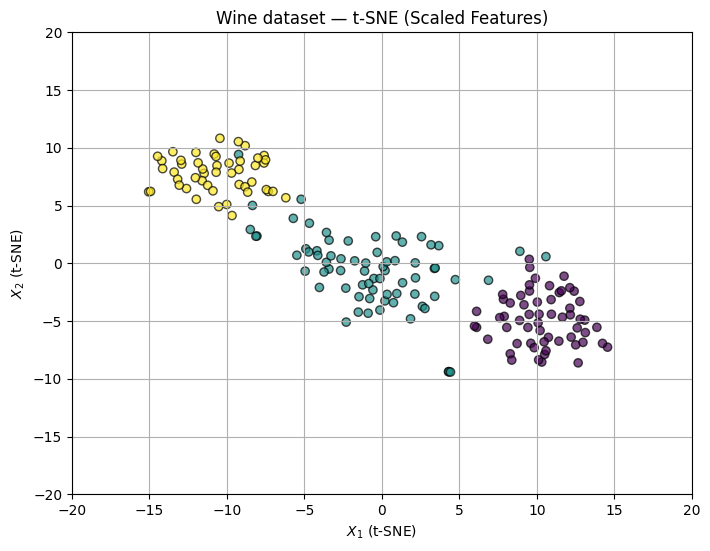

In [17]:
from sklearn.manifold import TSNE

X_scaled_full = StandardScaler().fit_transform(X)
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled_full)

plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis', edgecolor='k', alpha=0.7)
plt.xlabel("$X_1$ (t-SNE)")
plt.ylabel("$X_2$ (t-SNE)")
plt.axis([-20, 20, -20, 20])
plt.title("Wine dataset — t-SNE (Scaled Features)")
plt.grid(True)
plt.show()

## Distance Metric Considerations
Choosing a distance metric is itself a hyperparameter. For continuous features, **Euclidean (L2)** is the default and measures straight-line distance; **Manhattan (L1)** sums absolute differences and can be more robust to outliers. For text documents or high‑dimensional sparse data, **cosine similarity/distance** (which measures the angle between vectors) is often more meaningful than raw Euclidean distance. In practice, treat the metric as something to tune by validation.

> **Question**: Suppose you are using KNN to classify text documents represented by word counts (high-dimensional, sparse features). Which distance measure would most likely be more appropriate than Euclidean for this task, and why? distance & why?
>
> A Cosine similarity/distance  
>
> B Manhattan distance  
>
> C Hamming distance  
>
> D No difference


To see the effect of different metrics and K values, we can do a small grid of {Euclidean, Manhattan} × {3, 5, 7, 9} on the validation set. This isn’t exhaustive but shows that **distance metric** is a tunable choice.


In [18]:
from itertools import product

metrics = ['euclidean', 'manhattan']
k_values = [3, 5, 7, 9]
rows = []

for metric, k in product(metrics, k_values):
    mdl = KNeighborsClassifier(n_neighbors=k, metric=metric).fit(X_train_scaled, y_train)
    acc = accuracy_score(y_val, mdl.predict(X_val_scaled))
    rows.append((metric, k, acc))

grid_df = pd.DataFrame(rows, columns=['metric', 'k', 'val_accuracy']) \
          .pivot(index='metric', columns='k', values='val_accuracy')
grid_df


k,3,5,7,9
metric,,,,
euclidean,0.888889,0.944444,0.944444,0.916667
manhattan,0.916667,0.944444,0.944444,0.944444


## Choosing K: Bias–Variance Trade‑off
A small K (e.g., K=1) is highly flexible and fits training data very closely—**high variance** and potential overfitting. A very large K (approaching the size of the training set) averages over many neighbors—**high bias** and potential underfitting. We sweep K from 1 to 20 and plot training vs. validation accuracy to pick the best K by validation performance.

> **Question**: K=1 gives 100% train accuracy but only 88% validation. What should you do?
>  
> A) Increase K to reduce variance (overfitting).  
>
> B) Decrease K further  
>
> C) Change to Manhattan distance  
>
> D) Add more features


Best K (validation): 10 Validation accuracy: 0.972
Max (train - validation) gap across K: 0.102


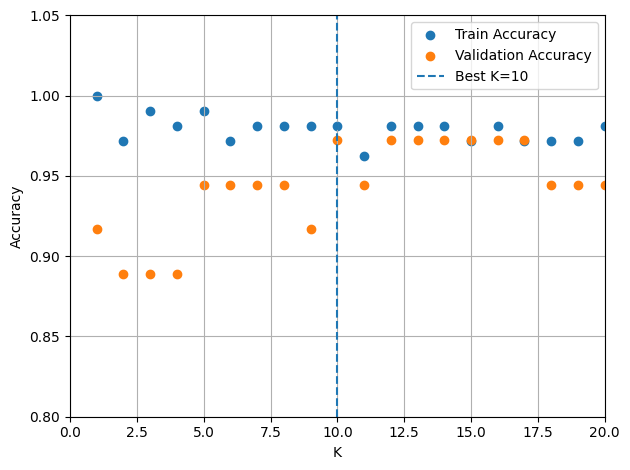

In [25]:
train_acc, val_acc = [], []
k_sweep = range(1, 21)

for k in k_sweep:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train_scaled, y_train)
    train_acc.append(accuracy_score(y_train, model.predict(X_train_scaled)))
    val_acc.append(accuracy_score(y_val, model.predict(X_val_scaled)))

# Best K by validation
best_k = int(np.argmax(val_acc) + 1)
best_val = max(val_acc)
max_gap = np.max(np.array(train_acc) - np.array(val_acc))

print("Best K (validation):", best_k, "Validation accuracy:", round(best_val, 3))
print("Max (train - validation) gap across K:", round(max_gap, 3))

# Plot train vs validation accuracy vs K
plt.figure()
plt.scatter(list(k_sweep), train_acc, label='Train Accuracy')
plt.scatter(list(k_sweep), val_acc, label='Validation Accuracy')
plt.axvline(best_k, linestyle='--', label=f'Best K={best_k}')
plt.axis([0, 20, 0.8, 1.05])
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()


### Distance-Weighted Voting vs. Uniform Voting
By default, KNN assigns equal weight to all K neighbors. Alternatively, you can weigh each neighbor by the inverse of its distance (`weights='distance'`), so closer neighbors matter more. This often helps when data has clusters of varying density.

**Tie Policy:** scikit-learn does not expose an explicit tie-breaking policy; ties depend on internal neighbor order. To reduce ties, prefer **odd K** or use distance weighting, which often makes ties less likely.


In [26]:
# Uniform voting (best_k from validation sweep)
knn_uniform = KNeighborsClassifier(n_neighbors=best_k, weights='uniform').fit(X_train_scaled, y_train)
uniform_val_acc = accuracy_score(y_val, knn_uniform.predict(X_val_scaled))

# Distance-weighted voting
knn_distance = KNeighborsClassifier(n_neighbors=best_k, weights='distance').fit(X_train_scaled, y_train)
distance_val_acc = accuracy_score(y_val, knn_distance.predict(X_val_scaled))

print(f'Validation acc (uniform weights @K={best_k}): {uniform_val_acc:.3f}')
print(f'Validation acc (distance weights @K={best_k}): {distance_val_acc:.3f}')


Validation acc (uniform weights @K=10): 0.972
Validation acc (distance weights @K=10): 0.944


## Abstain Rule (Coverage vs. Accuracy)
In quality‑assurance settings, we might prefer the classifier to **abstain** from labeling a new sample when it is far from all known samples. One simple strategy uses the **average distance to the K nearest neighbors** as a confidence proxy: if the average distance is too large, abstain (i.e. defer to a human or more expensive test). The plot below shows the trade‑off between **coverage** (fraction of samples automatically classified) and **accuracy on the kept cases** for various distance thresholds.

Pick a point based on your cost trade‑offs—for example, require ≥0.98 accuracy on kept cases even if coverage drops to ~0.7.


{'threshold': 2.5036290276275013, 'coverage': 0.5, 'acc_on_kept': 1.0}
{'threshold': 2.710184347350106, 'coverage': 0.6944444444444444, 'acc_on_kept': 1.0}
{'threshold': 3.3373283449302713, 'coverage': 0.8888888888888888, 'acc_on_kept': 1.0}


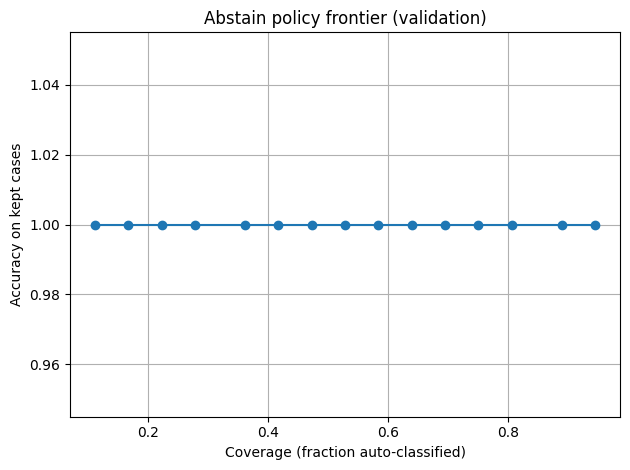

In [27]:
# Compute average distance to K neighbors (validation set)
mdl = KNeighborsClassifier(n_neighbors=best_k).fit(X_train_scaled, y_train)
distances, _ = mdl.kneighbors(X_val_scaled, n_neighbors=best_k, return_distance=True)
avg_kdist = distances.mean(axis=1)

def evaluate_with_abstain(th):
    keep = avg_kdist <= th
    if keep.sum() == 0:
        return {"threshold": float(th), "coverage": 0.0, "acc_on_kept": None}
    yhat = mdl.predict(X_val_scaled[keep])
    return {"threshold": float(th), "coverage": float(keep.mean()),
            "acc_on_kept": float(accuracy_score(y_val[keep], yhat))}

# Print a few sample thresholds
for th in np.quantile(avg_kdist, [0.5, 0.7, 0.9]):
    print(evaluate_with_abstain(th))

# Plot coverage vs accuracy on kept cases across many thresholds
ths = np.quantile(avg_kdist, np.linspace(0.1, 0.95, 15))
coverage_vals, accuracy_vals = [], []
for th in ths:
    result = evaluate_with_abstain(th)
    coverage_vals.append(result['coverage'])
    accuracy_vals.append(result['acc_on_kept'])

plt.figure()
plt.plot(coverage_vals, accuracy_vals, marker='o')
plt.xlabel("Coverage (fraction auto-classified)")
plt.ylabel("Accuracy on kept cases")
plt.title("Abstain policy frontier (validation)")
plt.grid(True)
plt.tight_layout()
plt.show()


## Selecting the Final Hyperparameters
We now choose the **metric**, **K**, and **weights** using evidence from the validation set. The logic is:

1. Pick the `(metric, K)` pair from our mini grid with the highest validation accuracy.  
2. Compare `weights='uniform'` vs `weights='distance'` for that pair to pick the better.  
3. Document the decision and use these hyperparameters for the final model.


In [28]:
# Step 1: choose metric & k from the mini grid with highest validation accuracy
try:
    best_cell = grid_df.stack().astype(float).idxmax()  # (metric, k)
    chosen_metric, chosen_k = best_cell[0], int(best_cell[1])
except Exception:
    chosen_metric, chosen_k = 'euclidean', int(best_k)

# Step 2: compare weights for chosen_metric and chosen_k
mdl_uniform  = KNeighborsClassifier(n_neighbors=chosen_k, metric=chosen_metric, weights='uniform')
mdl_distance = KNeighborsClassifier(n_neighbors=chosen_k, metric=chosen_metric, weights='distance')
mdl_uniform.fit(X_train_scaled, y_train)
mdl_distance.fit(X_train_scaled, y_train)

val_uniform  = accuracy_score(y_val, mdl_uniform.predict(X_val_scaled))
val_distance = accuracy_score(y_val, mdl_distance.predict(X_val_scaled))

chosen_weights = 'distance' if val_distance > val_uniform else 'uniform'

print("Decision log — chosen params:")
print({"metric": chosen_metric, "n_neighbors": chosen_k, "weights": chosen_weights})


Decision log — chosen params:
{'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'}


## Model Evaluation on Test Set
With the chosen hyperparameters, we refit KNN (within a pipeline to avoid leakage) on the combined training + validation data and evaluate performance on the **held-out test** set. This provides an unbiased estimate of real-world performance.

> **Question**: Test accuracy is slightly worse than validation. Before deployment, what’s the right approach?
>  
> A Check if the gap is variance/representativeness (e.g. re-run the split or consider temporal splits) and confirm test performance meets requirements.
>
> B Re-tune hyperparameters on the test set.  
>
> C Ignore the difference and deploy immediately.  
>
> D Conclude there was leakage.


In [29]:
# Combine training and validation sets for final training
X_train_all = np.vstack([X_train, X_val])
y_train_all = np.hstack([y_train, y_val])

# Build pipeline (scaler + KNN) with chosen hyperparameters
final_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=chosen_k, metric=chosen_metric, weights=chosen_weights))
])
final_pipe.fit(X_train_all, y_train_all)

# Predict on test set
test_pred = final_pipe.predict(X_test)
test_acc  = accuracy_score(y_test, test_pred)

print("Test accuracy:", round(test_acc, 3))


Test accuracy: 0.972


Beyond accuracy, we examine **balanced accuracy** (accounts for class imbalance) and **macro F1** (averages F1 across classes), print a **classification report**, show a **per-class table**, and plot both the raw and normalized confusion matrices.



Classification report (test):
              precision    recall  f1-score   support

           0      1.000     1.000     1.000        12
           1      1.000     0.933     0.966        15
           2      0.900     1.000     0.947         9

    accuracy                          0.972        36
   macro avg      0.967     0.978     0.971        36
weighted avg      0.975     0.972     0.972        36



,precision,recall,f1,support
0,1.0,1.000000,1.000000,12
1,1.0,0.933333,0.965517,15
2,0.9,1.000000,0.947368,9


Balanced accuracy (test): 0.978
Macro F1 (test):          0.971


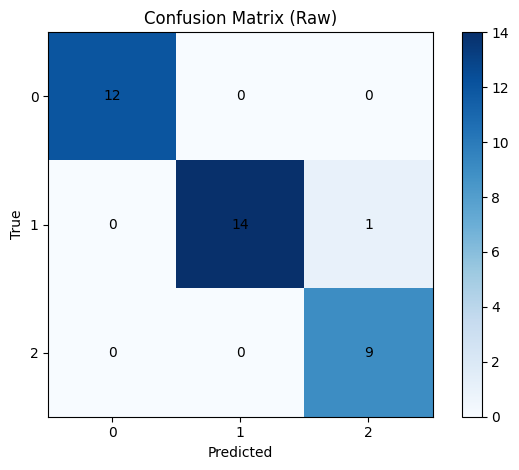

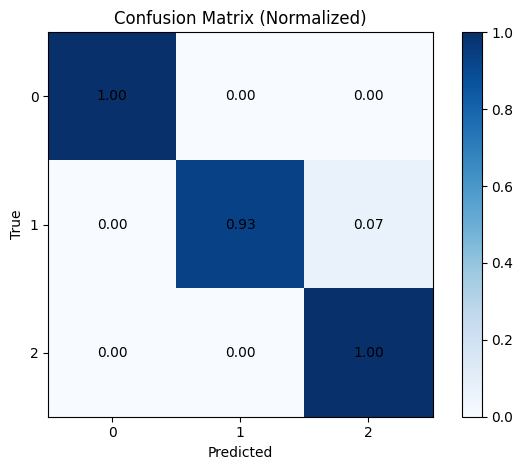

In [31]:
# Print classification report and per-class metrics
print("\nClassification report (test):")
print(classification_report(y_test, test_pred, digits=3, target_names=[str(c) for c in np.unique(y)]))

labels = list(np.unique(y))
prec, rec, f1, sup = precision_recall_fscore_support(y_test, test_pred, labels=labels)

per_class_df = pd.DataFrame({
    'precision': prec,
    'recall': rec,
    'f1': f1,
    'support': sup
}, index=labels)
display(per_class_df)

# Balanced accuracy & macro F1
print("Balanced accuracy (test):", round(balanced_accuracy_score(y_test, test_pred), 3))
print("Macro F1 (test):         ", round(f1_score(y_test, test_pred, average='macro'), 3))

# Confusion matrices: raw and normalized
cm_raw = confusion_matrix(y_test, test_pred, labels=labels)
cm_norm = confusion_matrix(y_test, test_pred, labels=labels, normalize='true')

# Raw confusion matrix heatmap
fig, ax = plt.subplots()
im = ax.imshow(cm_raw, cmap='Blues')
ax.set_xticks(range(len(labels)))
ax.set_yticks(range(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix (Raw)")
for i in range(len(labels)):
    for j in range(len(labels)):
        ax.text(j, i, cm_raw[i, j], ha='center', va='center', color='black')
fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

# Normalized confusion matrix heatmap
fig, ax = plt.subplots()
im = ax.imshow(cm_norm, vmin=0, vmax=1, cmap='Blues')
ax.set_xticks(range(len(labels)))
ax.set_yticks(range(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix (Normalized)")
for i in range(len(labels)):
    for j in range(len(labels)):
        ax.text(j, i, f"{cm_norm[i, j]:.2f}", ha='center', va='center', color='black')
fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()


## Nearest-Neighbors Sanity Probe
To interpret KNN decisions, we can list the indices, classes, and distances of the K nearest training samples for a few randomly chosen test samples. The vote tally makes it clear why a certain class was predicted.


In [32]:
# Compute scaled versions for neighbor analysis
scaler_fitted = final_pipe.named_steps['scaler']
knn_fitted    = final_pipe.named_steps['knn']
X_train_all_scaled = scaler_fitted.transform(X_train_all)
X_test_scaled = scaler_fitted.transform(X_test)

def show_neighbors_with_vote(i):
    x = X_test_scaled[i]
    d = pairwise_distances(X_train_all_scaled, [x]).ravel()
    idx = np.argsort(d)[:knn_fitted.n_neighbors]
    votes = Counter(y_train_all[idx])
    print(f"— Test idx {i}: true={y_test[i]}, pred={test_pred[i]}, votes={dict(votes)}")
    print("  neighbors (train_index | class | distance):")
    for j in idx:
        print(f"    {j:3d} | {y_train_all[j]} | {d[j]:.3f}")

# Show neighbors for three random test points
for i in np.random.RandomState(42).choice(len(X_test), size=3, replace=False):
    show_neighbors_with_vote(int(i))


— Test idx 35: true=2, pred=2, votes={np.int64(2): 4, np.int64(1): 1}
  neighbors (train_index | class | distance):
     61 | 2 | 2.195
     81 | 2 | 2.602
     63 | 1 | 2.782
     85 | 2 | 2.936
    102 | 2 | 3.293
— Test idx 13: true=1, pred=1, votes={np.int64(1): 5}
  neighbors (train_index | class | distance):
     76 | 1 | 3.021
     94 | 1 | 3.158
    114 | 1 | 3.292
     19 | 1 | 3.393
     88 | 1 | 3.560
— Test idx 26: true=1, pred=1, votes={np.int64(1): 5}
  neighbors (train_index | class | distance):
     21 | 1 | 1.456
     54 | 1 | 2.182
    126 | 1 | 2.374
     17 | 1 | 2.389
     62 | 1 | 2.562


## Limitations (Current Scope) & What’s Next
This notebook uses a **single hold‑out validation** set, which is simple but sensitive to data splits. In practice, data scientists often use **k‑fold cross‑validation** or nested validation to obtain more reliable estimates and avoid overfitting hyperparameters to a single split. We also used brute‑force neighbor search (`algorithm='brute'`) and didn’t explore scalability techniques like KD‑trees, Ball Trees, or approximate nearest neighbor libraries (e.g. FAISS, HNSW). These become important when your archive grows to millions of rows or requires low‑latency predictions. Finally, we didn’t address class imbalance or cost‑sensitive KNN; these are natural extensions for more advanced courses.

Use this foundational KNN workflow as a baseline. As you advance, you’ll learn to replace simple hold‑out validation with cross‑validation, integrate model pipelines into production, and explore neighbor indexing structures to scale your models.


## Conclusion
- **Scaling** prevents large‑range features from dominating distance computations.  
- **Tuning K** via validation balances bias and variance; a very small K overfits, a very large K underfits.  
- **Distance metric and weight** choices are hyperparameters; small grids reveal significant differences.  
- **Abstain rules** are valuable in quality‑assurance workflows, trading coverage for reliability.  
- **Pipeline and test evaluation** ensure leak‑free preprocessing and unbiased performance estimates.  
- KNN remains a powerful, intuitive baseline—use it to build intuition about distance and similarity before advancing to more sophisticated models.
